In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

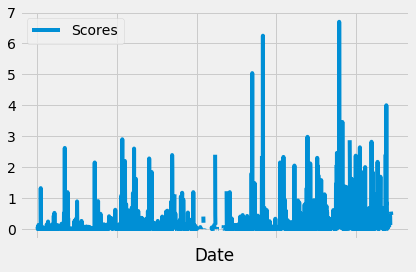

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = dt.datetime(2016, 8, 23)

percipitation_data=session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date>date).all()
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(percipitation_data,columns=["Date","Scores"])
# Sort the dataframe by date
df.set_index('Date',inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,Scores
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).group_by('station').count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by('station').\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
              filter(Measurement.station=="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001709632F908>]],
      dtype=object)

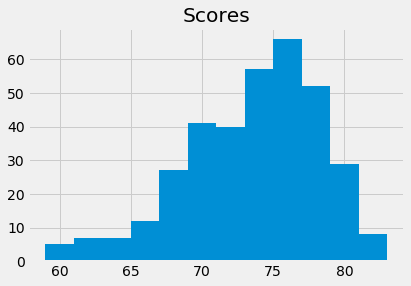

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp=session.query(Measurement.tobs).\
filter(Measurement.station=="USC00519281").\
filter(Measurement.date>date).all()
df_highest_temp=pd.DataFrame(highest_temp,columns=['Scores'])
df_highest_temp.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_chart=calc_temps('2011-02-28', '2011-03-05')
temps_chart

[(61.0, 69.75510204081633, 75.0)]

<BarContainer object of 1 artists>

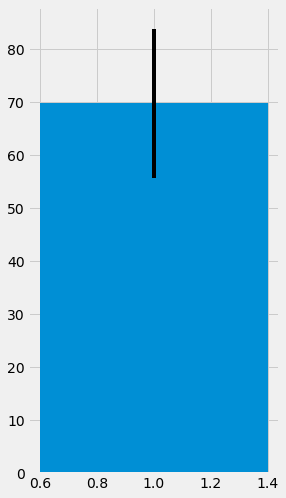

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps_chart=pd.DataFrame(temps_chart,columns=['Min','Avg','Max'])
diff=temps_chart['Max']-temps_chart['Min']
plt.figure(figsize=(4, 8))
plt.bar(1,temps_chart["Avg"],yerr=diff)

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
filter(Station.station==Measurement.station).\
filter(Measurement.date >= '2016-02-28').filter(Measurement.date <= '2016-03-28').\
group_by('station').\
order_by('station').all()

[('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.6499999999999995),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.43),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.05),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.67),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.43000000000000005),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.7600000000000002)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
